# KAIST Summer Session 2018

## Reply Bot_v2 based on Sequence-to-Sequence (08.23.2018)

- This code is adapted from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.
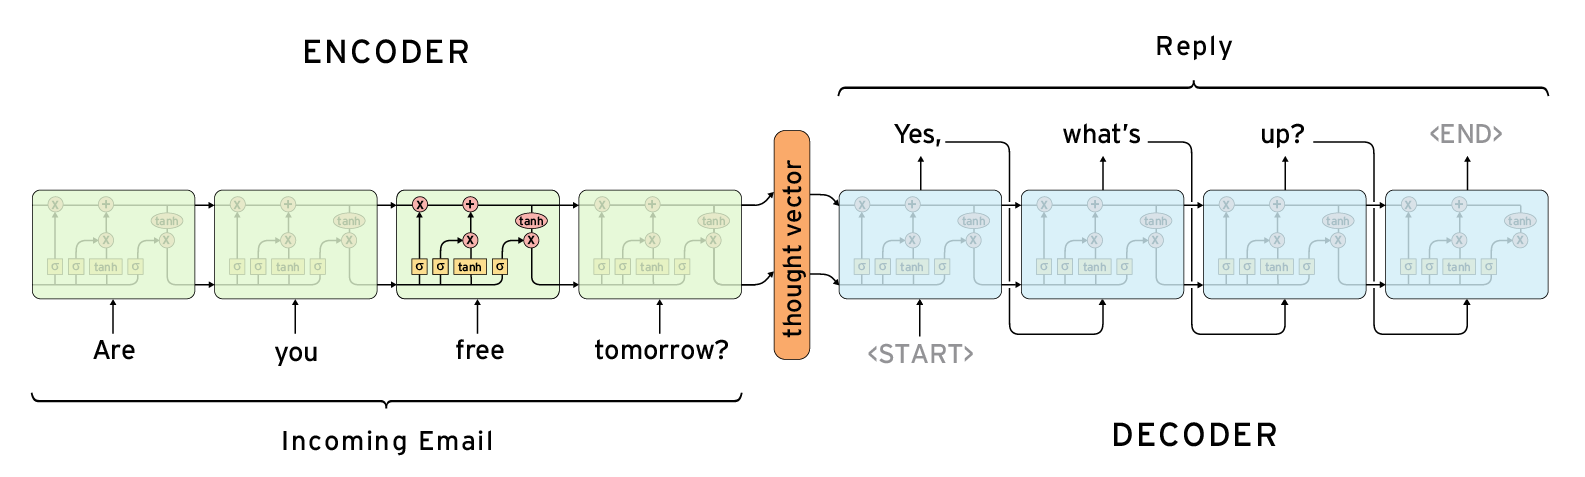

### 0. Data Preparation

In [1]:
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

MAX_LENGTH = 5
hidden_size = 256
learning_rate = 0.01
dropout_p = 0.1
n_layers = 1
n_epochs = 200

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def normalizeString(s):
    s = re.sub('[./?!\']', '', s)
    s = re.sub('\ufeff', '', s)
    return s.lower()


def lengthfilter(pairs):
    return [pair for pair in pairs if len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH]


def prepareData():
    lines = open('reply bot.csv').read().strip().split('\n')    
    pairs = [[normalizeString(s) for s in l.split(',')] for l in lines]
    input_lang = Lang('input')
    output_lang = Lang('output')
    pairs = lengthfilter(pairs)
    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        print(pair)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:", input_lang.n_words + output_lang.n_words)
    return input_lang, output_lang, pairs


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [4]:
input_lang, output_lang, pairs = prepareData()

training_pairs = [tensorsFromPair(pairs[i]) for i in range(len(pairs))]

Read 11 sentence pairs
['나 살찐 거 같지', '예뻐']
['나 어때', '예쁘네']
['오늘 옷 어때', '예뻐']
['이 옷 잘 어울려', '예쁘다']
['오늘 나 어때', '완전 예뻐']
['나 힘들어', '부장님이 잘못했네']
['컨디션 최악이야', '부장님이 잘못했군']
['오늘 회사에서 힘들었어', '부장님이 잘못했어']
['회사 관두고 싶어', '부장님이 잘못한거 같아']
['짜증나', '부장님이 완전 잘못했네']
['오늘 있잖아', '부장님이 잘못했잖아']
Counted words: 35


### 1. Define a Neural Network

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)


- Decoder RNN with Attention
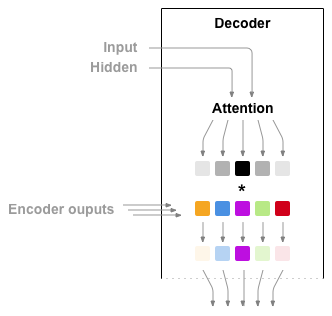

In [6]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size,n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, n_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output,hidden = self.gru(output,hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        return hidden

### 2. Define a Loss Function and Optimizer

In [7]:
# Instantiate the seq2seq model
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Set loss and optimizer function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

### 3. Training

In [8]:
print_every = n_epochs//10
print_loss_total = 0

encoder.train()
decoder.train()

for epoch in range(1, n_epochs+1):
    for i in range(len(pairs)):        
        training_pair = training_pairs[i]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1] 
        
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0
    
        # Encoding
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size)
        encoder_hidden = encoder.init_hidden()
    
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        
        # Decoding using the encoded representation    
        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing


        # Updating
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
            
        loss.backward()
            
        encoder_optimizer.step()
        decoder_optimizer.step()            
            
        print_loss_total += loss.item()
        
        
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('Epoch {:d} ({:.0f}%) {:.4f}'.format(epoch, epoch / n_epochs * 100, print_loss_avg))
        
print("Learning finished!")

Epoch 20 (10%) 15.5782
Epoch 40 (20%) 0.1637
Epoch 60 (30%) 0.0679
Epoch 80 (40%) 0.0394
Epoch 100 (50%) 0.0255
Epoch 120 (60%) 0.0182
Epoch 140 (70%) 0.0136
Epoch 160 (80%) 0.0103
Epoch 180 (90%) 0.0081
Epoch 200 (100%) 0.0065
Learning finished!


### 4. Evaluation

In [9]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()   
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]])  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

    return decoded_words, decoder_attentions[:di + 1, :input_length]

- Let's see how the model works well
- Attention allows us to visualize which inputs have paid attention to which outputs

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words.split(' '))

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # show_plot_visdom()
    plt.show()
    plt.close()

Question:  짜증나
Reply Bot's Answer:  부장님이 완전 잘못했네 <EOS>



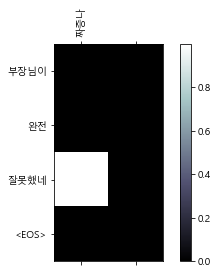

Question:  오늘 있잖아
Reply Bot's Answer:  부장님이 잘못했잖아 <EOS>



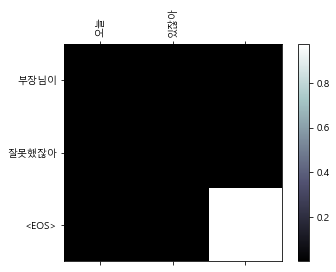

Question:  나 힘들어
Reply Bot's Answer:  부장님이 잘못했네 <EOS>



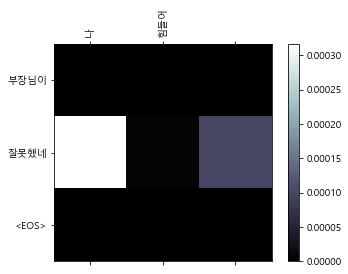

Question:  오늘 회사에서 힘들었어
Reply Bot's Answer:  부장님이 잘못했어 <EOS>



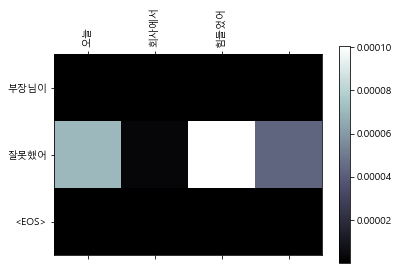

Question:  오늘 나 어때
Reply Bot's Answer:  완전 예뻐 <EOS>



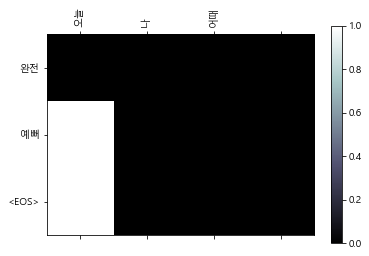

In [13]:
for i in range(5):
    pair = random.choice(pairs)
    print('Question: ', pair[0])
    output_words, attentions = evaluate(encoder, decoder, pair[0])
    output_sentence = ' '.join(output_words)
    print('Reply Bot\'s Answer: ', output_sentence)
    print('')
    show_attention(pair[0], output_sentence, attentions.data)